In [2]:
# !pip install --user  sidechainnet

In [3]:
# pip install openmm

In [4]:
# pip install pytorch_lightning

### IMPORTS

In [5]:
import sidechainnet as scn
import numpy as np
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from pytorch_lightning import callbacks
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
import torch
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
from pytorch_lightning.callbacks import LearningRateMonitor
from tqdm.notebook import tqdm
from scipy import stats
import py3Dmol
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(0)
pl.seed_everything(10701)

# SidechainNet imports
from sidechainnet.dataloaders.SCNProtein import OPENMM_FORCEFIELDS
from sidechainnet.structure.structure import inverse_trig_transform
from sidechainnet.structure.build_info import NUM_ANGLES
from sidechainnet.examples.lightning.LitSidechainDemo import LitSidechainTransformerBaseModule, LitSCNDataModule
from sidechainnet.examples.transformer import PositionalEncoding
from sidechainnet.utils.sequence import VOCAB
from sidechainnet.utils.download import MAX_SEQ_LEN
from sidechainnet.dataloaders.SCNProtein import SCNProtein
from sidechainnet.dataloaders.ProteinBatch import ProteinBatch
from sidechainnet.examples.losses import gdc_all

# Check device
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using {device} for training.")

/home/sahil/.config/matplotlib is not a writable directory
Matplotlib created a temporary cache directory at /tmp/matplotlib-2lvm7jer because there was an issue with the default path (/home/sahil/.config/matplotlib); it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Seed set to 10701


Using cuda for training.


### ENHANCED EVALUATION METRICS

In [6]:
class EnhancedEvaluationMetrics:
    """
    Enhanced evaluation metrics combining SidechainNet approach with paper metrics
    Implements dRMSD, torsion RMSE, and statistical significance testing from the paper
    """
    
    def __init__(self):
        self.drmsd_values = []
        self.rmse_torsion_values = []
        self.rmsd_values = []
        self.gdc_values = []
        
    def compute_drmsd(self, true_coords, pred_coords):
        """
        Compute distance RMSD as described in the paper (Equation 11)
        This is rotation/translation invariant
        """
        
        # Handle different input shapes
        if len(true_coords.shape) == 3:  # (residues, atoms, 3)
            true_coords = true_coords.reshape(-1, 3)
            pred_coords = pred_coords.reshape(-1, 3)
        
        # Remove NaN coordinates
        valid_mask = ~(np.isnan(true_coords).any(axis=-1) | np.isnan(pred_coords).any(axis=-1))
        true_coords_clean = true_coords[valid_mask]
        pred_coords_clean = pred_coords[valid_mask]
        
        if len(true_coords_clean) < 2:
            return float('nan')
        
        # Compute distance matrices (Equation 9)
        def distance_matrix(coords):
            """Compute pairwise distance matrix"""
            n = len(coords)
            if n == 0:
                return np.array([])
            
            # Vectorized distance computation
            coords_expanded = coords[:, np.newaxis, :]  # (n, 1, 3)
            coords_tiled = coords[np.newaxis, :, :]     # (1, n, 3)
            diff = coords_expanded - coords_tiled        # (n, n, 3)
            dist_matrix = np.sqrt(np.sum(diff**2, axis=2))  # (n, n)
            return dist_matrix
        
        true_dist_matrix = distance_matrix(true_coords_clean)
        pred_dist_matrix = distance_matrix(pred_coords_clean)
        
        # Compute dRMSD following paper's equation (10) and (11)
        diff_matrix = true_dist_matrix - pred_dist_matrix  # Equation (10)
        L = len(true_coords_clean)
        
        # Only use upper triangle (avoid double counting)
        upper_triangle_mask = np.triu(np.ones_like(diff_matrix, dtype=bool), k=1)
        diff_upper = diff_matrix[upper_triangle_mask]
        
        drmsd = np.sqrt(np.sum(diff_upper**2) / (L * (L - 1) / 2))  # Equation (11)
        
        return drmsd
    
    def compute_torsion_rmse(self, true_angles, pred_angles):
        """
        Compute RMSE of torsion angles as described in the paper
        Following equations (12), (13), (14)
        """
        # Handle NaN values
        if len(true_angles.shape) == 2 and len(pred_angles.shape) == 2:
            # Flatten if needed
            true_angles_flat = true_angles.flatten()
            pred_angles_flat = pred_angles.flatten()
        else:
            true_angles_flat = true_angles
            pred_angles_flat = pred_angles
            
        valid_mask = ~(np.isnan(true_angles_flat) | np.isnan(pred_angles_flat))
        true_angles_clean = true_angles_flat[valid_mask]
        pred_angles_clean = pred_angles_flat[valid_mask]
        
        if len(true_angles_clean) == 0:
            return float('nan')
        
        
        # Compute angle differences (equation 12)
        angle_diffs = np.abs(true_angles_clean - pred_angles_clean)

        # Handle circular nature of angles (equation 13)
        angle_diffs_corrected = np.minimum(2 * np.pi - angle_diffs, angle_diffs)
        
        # Compute RMSE (equation 14)
        rmse = np.sqrt(np.mean(angle_diffs_corrected**2))
        
        # Convert to degrees for interpretability
        # rmse_degrees = rmse * 180 / np.pi

        return rmse
    
    def compute_batch_metrics(self, true_batch, predicted_batch):
        """
        Compute all metrics for a batch of proteins
        """
        drmsd_list = []
        rmse_torsion_list = []
        rmsd_list = []
        gdc_list = []
        
        for true_prot, pred_prot in zip(true_batch, predicted_batch):
            try:
                # dRMSD computation
                if hasattr(true_prot, 'coords') and hasattr(pred_prot, 'coords'):
                    # Ensure coords are numpy arrays
                    true_coords = true_prot.coords if isinstance(true_prot.coords, np.ndarray) else true_prot.coords.numpy()
                    pred_coords = pred_prot.coords if isinstance(pred_prot.coords, np.ndarray) else pred_prot.coords.numpy()
                    
                    drmsd = self.compute_drmsd(true_coords, pred_coords)
                    if not np.isnan(drmsd):
                        drmsd_list.append(drmsd)
                
                if hasattr(true_prot, 'angles') and hasattr(pred_prot, 'angles'):
                    true_angles = true_prot.angles if isinstance(true_prot.angles, np.ndarray) else true_prot.angles.numpy()
                    pred_angles = pred_prot.angles if isinstance(pred_prot.angles, np.ndarray) else pred_prot.angles.numpy()
                    
                    true_torsion = true_angles[:, 6:]
                    pred_torsion = pred_angles[:, 6:]
                    
                    rmse_torsion = self.compute_torsion_rmse(true_torsion, pred_torsion)
                    if not np.isnan(rmse_torsion):
                        rmse_torsion_list.append(rmse_torsion)
                
                # Standard RMSD (from SidechainNet)
                rmsd = true_prot.rmsd(pred_prot)
                if not np.isnan(rmsd):
                    rmsd_list.append(rmsd)
                
                # GDC-All computation (similar to GDT-TS but for all atoms)
                try:
                    # Prepare coordinates for GDC computation
                    true_coords = true_prot.coords if isinstance(true_prot.coords, np.ndarray) else true_prot.coords.numpy()
                    pred_coords = pred_prot.coords if isinstance(pred_prot.coords, np.ndarray) else pred_prot.coords.numpy()
                    
                    # Mask any residues with NaNs
                    true_nan_mask = np.isnan(true_coords)
                    pred_nan_mask = np.isnan(pred_coords)
                    valid_res_mask = ~(true_nan_mask.any(axis=-1) | pred_nan_mask.any(axis=-1))
                    
                    if valid_res_mask.any():
                        true_coords_clean = true_coords[valid_res_mask]
                        pred_coords_clean = pred_coords[valid_res_mask]
                        
                        if len(true_coords_clean.reshape(-1, 3)) > 0:
                            gdc_score = gdc_all(true_coords_clean.reshape(-1, 3), pred_coords_clean.reshape(-1, 3))
                            if not np.isnan(gdc_score):
                                gdc_list.append(gdc_score)
                except:
                    pass  # Skip GDC if computation fails
                    
            except Exception as e:
                print(f"Warning: Error computing metrics for protein: {e}")
                continue
        
        return {
            'drmsd': np.mean(drmsd_list) if drmsd_list else float('nan'),
            'rmse_torsion': np.mean(rmse_torsion_list) if rmse_torsion_list else float('nan'),
            'rmsd': np.mean(rmsd_list) if rmsd_list else float('nan'),
            'gdc': np.mean(gdc_list) if gdc_list else float('nan'),
            'drmsd_std': np.std(drmsd_list) if len(drmsd_list) > 1 else 0.0,
            'rmse_torsion_std': np.std(rmse_torsion_list) if len(rmse_torsion_list) > 1 else 0.0,
            'rmsd_std': np.std(rmsd_list) if len(rmsd_list) > 1 else 0.0,
            'gdc_std': np.std(gdc_list) if len(gdc_list) > 1 else 0.0,
            'n_proteins': len(drmsd_list)
        }
    
    def statistical_significance_test(self, values1, values2, metric_name="metric"):
        """
        Perform T-test as described in the paper (equation 16)
        """
        # Remove NaN values
        values1_clean = [v for v in values1 if not np.isnan(v)]
        values2_clean = [v for v in values2 if not np.isnan(v)]
        
        if len(values1_clean) == 0 or len(values2_clean) == 0:
            return None
        
        # Perform two-sample t-test
        try:
            t_stat, p_value = stats.ttest_ind(values1_clean, values2_clean)
        except:
            return None
        
        # Determine significance (90% confidence interval as in paper)
        is_significant = p_value < 0.1
        
        return {
            'metric': metric_name,
            't_statistic': t_stat,
            'p_value': p_value,
            'is_significant': is_significant,
            'mean_diff': np.mean(values1_clean) - np.mean(values2_clean),
            'improvement': np.mean(values1_clean) < np.mean(values2_clean),  # True if values1 is better (lower)
            'effect_size': abs(np.mean(values1_clean) - np.mean(values2_clean)) / np.sqrt((np.var(values1_clean) + np.var(values2_clean)) / 2)
        }
    
    def store_epoch_metrics(self, metrics):
        """Store metrics for later analysis"""
        if not np.isnan(metrics['drmsd']):
            self.drmsd_values.append(metrics['drmsd'])
        if not np.isnan(metrics['rmse_torsion']):
            self.rmse_torsion_values.append(metrics['rmse_torsion'])
        if not np.isnan(metrics['rmsd']):
            self.rmsd_values.append(metrics['rmsd'])
        if not np.isnan(metrics['gdc']):
            self.gdc_values.append(metrics['gdc'])
    
    def plot_metrics_comparison(self, save_path=None):
        """Plot all metrics over training epochs"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        axes = axes.flatten()
        
        metrics_data = [
            (self.drmsd_values, 'dRMSD (Angstrom)', 'Distance RMSD over Training', 'blue'),
            (self.rmse_torsion_values, 'RMSE (degrees)', 'Torsion Angle RMSE over Training', 'red'),
            (self.rmsd_values, 'RMSD (Angstrom)', 'All-atom RMSD over Training', 'green'),
            (self.gdc_values, 'GDC Score', 'GDC-All Score over Training', 'purple')
        ]
        
        for i, (values, ylabel, title, color) in enumerate(metrics_data):
            if values:
                epochs = range(len(values))
                axes[i].plot(epochs, values, color=color, linewidth=2, marker='o', markersize=3)
                axes[i].set_xlabel('Epoch')
                axes[i].set_ylabel(ylabel)
                axes[i].set_title(title)
                axes[i].grid(True, alpha=0.3)
                
                # Add trend line
                if len(values) > 1:
                    z = np.polyfit(epochs, values, 1)
                    p = np.poly1d(z)
                    axes[i].plot(epochs, p(epochs), "--", alpha=0.7, color=color, label=f'Trend (slope: {z[0]:.4f})')
                    axes[i].legend()
            else:
                axes[i].text(0.5, 0.5, 'No data available', ha='center', va='center', transform=axes[i].transAxes)
                axes[i].set_title(title)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()

### COMPUTE BATCH RMSD FUNCTION

In [7]:
def compute_batch_rmsd(true_batch, predicted_angles_sincos):
    """Original function for backward compatibility"""
    predicted_batch = true_batch.copy()

    # Convert predicted sin/cos angles to radians
    predicted_angles_rad = inverse_trig_transform(predicted_angles_sincos, n_angles=6)

    for i, (sc_angs_rad, predicted_protein, true_protein) in enumerate(zip(predicted_angles_rad, predicted_batch, true_batch)):
        # Only assign up to the true protein length
        length = len(true_protein)

        # Assign radians angles to predicted protein sidechain angles slice
        predicted_protein.angles[:length, 6:] = sc_angs_rad.cpu().detach().numpy()[:length]

        # Build 3D coords from predicted angles
        predicted_protein.fastbuild(inplace=True)

    # Compute RMSD for each protein pair and average
    rmsd_list = []
    for pred_prot, true_prot in zip(predicted_batch, true_batch):
        rmsd_val = true_prot.rmsd(pred_prot)
        rmsd_list.append(rmsd_val)

    return sum(rmsd_list) / len(rmsd_list)

### ENHANCED MODEL CLASS 

In [8]:
class EnhancedLitSidechainTransformerDemo(LitSidechainTransformerBaseModule):
    """
    Enhanced PyTorch Lightning module combining SidechainNet with paper-based evaluation metrics
    """

    def __init__(
            self,
            # Model specific arguments
            d_seq_embedding=32,
            d_nonseq_data=35,  
            d_in=256,
            d_out=12,
            d_feedforward=512,
            n_heads=8,
            n_layers=6,
            transformer_activation='relu',
            sequence_only=True,
            # Training Arguments
            loss_name='mse',
            opt_name='adam',
            opt_lr=1e-5,
            opt_lr_scheduling='plateau',
            opt_lr_scheduling_metric='val_loss',
            opt_patience=20,
            opt_min_delta=0.01,
            opt_weight_decay=1e-3,
            opt_n_warmup_steps=2000,
            dropout=0.3,
            # Other
            dataloader_name_mapping=None,
            angle_means=None,
            **kwargs):
        """Create an Enhanced LitSidechainTransformer module."""
        super().__init__()
        self.automatic_optimization = True
        self.save_hyperparameters()

        # Enhanced evaluation metrics
        self.eval_metrics = EnhancedEvaluationMetrics()
        
        # Training tracking
        self.train_losses = []
        self.val_losses = []
        self._val_epoch_losses = [[] for _ in range(7)]
        self.train_rmsds = []
        self.val_rmsds = []
        self._val_rmsd_losses = [[] for _ in range(7)]
        
        # Initialize layers
        self.input_embedding = torch.nn.Embedding(num_embeddings=len(VOCAB),
                                                  embedding_dim=d_seq_embedding,
                                                  padding_idx=VOCAB.pad_id)
        torch.nn.init.normal_(self.input_embedding.weight, mean=0.0, std=0.02)
        self.input_embedding.weight.data[VOCAB.pad_id].zero_() 
        if sequence_only:
            self.ff1 = torch.nn.Linear(d_seq_embedding, d_in)
        else:
            self.ff1 = torch.nn.Linear(d_nonseq_data + d_seq_embedding, d_in)
            
        
        self.positional_encoding = PositionalEncoding(d_model=d_in, max_len=MAX_SEQ_LEN)
        self.norm1 = torch.nn.LayerNorm(d_in)
        # self.norm2 = torch.nn.LayerNorm(d_in)
        self.encoder_layer = torch.nn.TransformerEncoderLayer(
            d_model=d_in,
            nhead=n_heads,
            dim_feedforward=d_feedforward,
            dropout=dropout,
            activation=transformer_activation,
            batch_first=True,
            norm_first=True)
        self.transformer_encoder = torch.nn.TransformerEncoder(self.encoder_layer, num_layers=n_layers)
        self.ff2 = torch.nn.Linear(d_in, d_out)
        self.output_activation = torch.nn.Tanh()

        # Initialize model parameters
        self._init_parameters()
        if angle_means is not None:
            self._init_angle_mean_projection()

    # def configure_optimizers(self):
    #     # Updated parameter grouping with better learning rate ratios
    #     params = [
    #         {'params': self.input_embedding.parameters(), 'lr': self.hparams.opt_lr * 0.5},  # Increased from 0.1
    #         {'params': self.transformer_encoder.parameters(), 'lr': self.hparams.opt_lr},
    #         {'params': list(self.ff1.parameters()) + list(self.ff2.parameters()), 'lr': self.hparams.opt_lr * 1.5},  # Increased for output layers
    #         {'params': self.norm1.parameters(), 'lr': self.hparams.opt_lr},
    #         {'params': self.norm2.parameters(), 'lr': self.hparams.opt_lr},
    #     ]
    
    #     optimizer = torch.optim.AdamW(
    #         params,
    #         lr=self.hparams.opt_lr,
    #         weight_decay=self.hparams.opt_weight_decay,  # This should be 5e-3 based on your args
    #         betas=(0.9, 0.98),  # Better for transformers
    #         eps=1e-8  # Better numerical stability
    #     )
    
    #     # Monitor RMSD instead of RMSE - much more meaningful for structure prediction
    #     monitor_metric = "val_rmsd/dataloader_idx_6"  # CHANGED FROM RMSE TO RMSD
        
    #     # Adjusted scheduler parameters for protein structure prediction
    #     scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    #         optimizer,
    #         mode='min',
    #         factor=0.5,
    #         patience=10,  # Increased patience for protein data
    #         min_lr=1e-7,
    #         threshold=0.01,  # More appropriate for RMSD scale
    #     )
    
    #     return {
    #         "optimizer": optimizer,
    #         "lr_scheduler": {
    #             "scheduler": scheduler,
    #             "monitor": monitor_metric,  # Now monitoring RMSD
    #             "interval": "epoch",
    #             "frequency": 1
    #         }
    #     }

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(
            self.parameters(),
            lr=self.hparams.opt_lr,
            weight_decay=self.hparams.opt_weight_decay,
            betas=(0.9, 0.98),
            eps=1e-8
        )
        
        # Simple Plateau scheduler
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode='min',
            factor=0.5,           # Reduce LR by half
            patience=5,           # Wait 5 epochs without improvement
            min_lr=1e-6,          # Minimum learning rate
        )
        
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_rmse",  # Monitor validation RMSE
                "interval": "epoch",
                "frequency": 1
            }
        }

    def on_fit_start(self):
        self.train_losses = []
        self.val_losses = []
        self._val_epoch_losses = [[] for _ in range(7)]
        self._val_rmsd_losses = [[] for _ in range(7)]
        self.val_epoch_indices = []
        self.train_rmsds = []
        self.val_rmsds = []

    def forward(self, x, seq):
        """Run one forward step of the model."""
        device = next(self.parameters()).device
        x = x.to(device)
        seq = seq.to(device)

        padding_mask = self._get_seq_pad_mask(seq) #returns a boolean mask indicating which positions in the sequence are padding tokens
        seq = self.input_embedding(seq) #each token converted into a vector representation 
        # if torch.isnan(seq).any():
        #     print("NaN detected in embeddings!")
        #     seq = torch.nan_to_num(seq, nan=0.0)

        if self.hparams.sequence_only:
            x = seq
        else:
            x = torch.cat([x, seq], dim=-1)

        x = self.ff1(x)
        x = self.positional_encoding(x)
        x = self.norm1(x)
        # x = self.norm2(x)
        x = self.transformer_encoder(x, src_key_padding_mask=padding_mask)
        x = self.ff2(x)
        x = self.output_activation(x)

        # if torch.isinf(x).any():
        #     x = torch.nan_to_num(x, posinf=1.0, neginf=-1.0)
        return x
    
    def _prepare_model_input(self, batch):
        batch.set_device(self.device)
        batch.fillna(0.0)

        bb_angs = batch.angles[:, :, :6] #backbone angles 
        sc_angs_true_untransformed = batch.angles[:, :, 6:] #sidechain angles

        sc_angs_true = scn.structure.trig_transform(sc_angs_true_untransformed).reshape(
            sc_angs_true_untransformed.shape[0], sc_angs_true_untransformed.shape[1], 12)

        model_in = torch.cat([bb_angs, batch.secondary, batch.evolutionary], dim=-1)
        return model_in, sc_angs_true


    def training_step(self, batch, batch_idx):
        """Enhanced training step with comprehensive metrics."""
        model_in, sc_angs_true = self._prepare_model_input(batch)
        sc_angs_pred = self(model_in, batch.seqs_int)

        # Compute RMSE loss
        loss_dict = self._get_losses(batch, sc_angs_true, sc_angs_pred,do_struct=batch_idx == 0, split='train')
        rmse_loss = torch.sqrt(loss_dict['loss'])
        
        # Compute RMSD for tracking
        # avg_rmsd = compute_batch_rmsd(batch, sc_angs_pred)
        
        # Log metrics
        # self.log('train_rmsd', avg_rmsd, on_step=False, on_epoch=True, prog_bar=True, batch_size=len(batch))
        self.log('train_rmse', rmse_loss, on_step=False, on_epoch=True, prog_bar=True, batch_size=len(batch))
        
        return loss_dict['loss']

    def validation_step(self, batch, batch_idx, dataloader_idx=0):
        """Run enhanced metrics more often - that's where the value is"""
        model_in, sc_angs_true = self._prepare_model_input(batch)
        sc_angs_pred = self(model_in, batch.seqs_int)
    
        # Keep your existing loss computation
        loss_dict = self._get_losses(batch, sc_angs_true, sc_angs_pred, split='val')
        rmse = torch.sqrt(loss_dict['loss'])
        
        # Keep your existing logging
        self.log(f'val_rmse', rmse, on_step=False, on_epoch=True, prog_bar=True, batch_size=len(batch), add_dataloader_idx=True)
        
        # val_rmsd = compute_batch_rmsd(batch, sc_angs_pred)
        # self.log(f'val_rmsd', val_rmsd, on_step=False, on_epoch=True, prog_bar=True, batch_size=len(batch), add_dataloader_idx=True)
        self.log(f'val_loss', loss_dict['loss'], on_step=False, on_epoch=True, batch_size=len(batch), add_dataloader_idx=True)
    
        # Run enhanced evaluation more frequently - this is the real value
        # if dataloader_idx == len(self._val_epoch_losses) - 1 and batch_idx % 5 == 0:  
        #     try:
        #         sc_angs_pred_rad = inverse_trig_transform(sc_angs_pred, n_angles=6)
                
        #         true_batch = batch.copy()
        #         predicted_batch = batch.copy()
                
        #         for i, (sc_angs, predicted_protein, true_protein) in enumerate(zip(sc_angs_pred_rad, predicted_batch, true_batch)):
        #             length = len(true_protein)
        #             predicted_protein.angles[:length, 6:] = sc_angs.cpu().detach().numpy()[:length]
        #             predicted_protein.fastbuild(inplace=True)
                
        #         enhanced_metrics = self.eval_metrics.compute_batch_metrics(true_batch, predicted_batch)
                
        #         # Log enhanced metrics
        #         if not np.isnan(enhanced_metrics['drmsd']):
        #             print(enhanced_metrics['drmsd'])
        #             self.log('val_drmsd', enhanced_metrics['drmsd'], on_step=False, on_epoch=True, prog_bar=True, batch_size=len(batch))
        #         if not np.isnan(enhanced_metrics['rmse_torsion']):
        #             self.log('val_torsion_rmse', enhanced_metrics['rmse_torsion'], on_step=False, on_epoch=True, prog_bar=True, batch_size=len(batch))
        #         if not np.isnan(enhanced_metrics['gdc']):
        #             self.log('val_gdc', enhanced_metrics['gdc'], on_step=False, on_epoch=True, prog_bar=True, batch_size=len(batch))
                
        #         self.eval_metrics.store_epoch_metrics(enhanced_metrics)
                    
        #     except Exception as e:
        #         print(f"Warning: Enhanced metrics computation failed: {e}")
        
        self._val_epoch_losses[dataloader_idx].append(rmse.detach().cpu().item())
        # self._val_rmsd_losses[dataloader_idx].append(val_rmsd)
    
        return loss_dict['loss']

    def on_train_epoch_end(self):
        # train_rmsd = self.trainer.callback_metrics.get('train_rmsd')
        train_rmse = self.trainer.callback_metrics.get('train_rmse')
        if train_rmse is not None:
            # self.train_rmsds.append(train_rmsd.detach().cpu().item())
            self.train_losses.append(train_rmse.detach().cpu().item())

    def on_validation_epoch_end(self):
        epoch = self.current_epoch
    
        # Flatten all val RMSE losses across dataloaders (0–6)
        all_val_rmses = [loss for dl_losses in self._val_epoch_losses for loss in dl_losses]
    
        # Flatten all val RMSD losses across dataloaders (0–6)
        # all_val_rmsds = [loss for dl_losses in self._val_rmsd_losses for loss in dl_losses]
    
        if all_val_rmses:
            avg_val_rmse = sum(all_val_rmses) / len(all_val_rmses)
            self.val_losses.append(avg_val_rmse)
            self.val_epoch_indices.append(epoch)
    
            # Log RMSE
            self.log("val_rmse", avg_val_rmse, prog_bar=True, on_epoch=True, sync_dist=True)
    
        # if all_val_rmsds:
        #     avg_val_rmsd = sum(all_val_rmsds) / len(all_val_rmsds)
        #     self.val_rmsds.append(avg_val_rmsd)
    
        #     # Log RMSD
        #     self.log("val_rmsd", avg_val_rmsd, prog_bar=True, on_epoch=True, sync_dist=True)
    
        # Reset for next epoch
        self._val_epoch_losses = [[] for _ in range(7)]
        # self._val_rmsd_losses = [[] for _ in range(7)]


### ANALYSIS FUNCTIONS

In [9]:
def analyze_results_like_paper(model, save_plots=True):
    """
    Comprehensive analysis following the paper's methodology
    """
    print("=" * 60)
    print("       ANALYSIS FOLLOWING PAPER METHODOLOGY")
    print("=" * 60)
    
    # Plot metrics over training
    if save_plots:
        model.eval_metrics.plot_metrics_comparison('enhanced_training_metrics.png')
    else:
        model.eval_metrics.plot_metrics_comparison()
    
    # Statistical significance analysis
    if len(model.eval_metrics.drmsd_values) > 10:
        recent_drmsd = model.eval_metrics.drmsd_values[-5:]
        early_drmsd = model.eval_metrics.drmsd_values[:5]
        
        significance_test = model.eval_metrics.statistical_significance_test(
            recent_drmsd, early_drmsd, "dRMSD training improvement"
        )
        
        if significance_test:
            print(f"\nStatistical Significance Test (Training Progress):")
            print(f"  Metric: {significance_test['metric']}")
            print(f"  T-statistic: {significance_test['t_statistic']:.3f}")
            print(f"  P-value: {significance_test['p_value']:.6f}")
            print(f"  Significant (p<0.1): {significance_test['is_significant']}")
            print(f"  Mean improvement: {significance_test['mean_diff']:.3f} Angstrom")
            print(f"  Effect size: {significance_test['effect_size']:.3f}")
    
    # Baseline comparison if available
    # if model.baseline_set and len(model.eval_metrics.drmsd_values) > 0:
    #     final_drmsd = [model.eval_metrics.drmsd_values[-1]] if model.eval_metrics.drmsd_values else []
    #     final_rmse_torsion = [model.eval_metrics.rmse_torsion_values[-1]] if model.eval_metrics.rmse_torsion_values else []
        
        # if final_drmsd:
            # baseline_comparison = model.eval_metrics.statistical_significance_test(
            #     final_drmsd, model.baseline_drmsd, "dRMSD vs Baseline"
            # )
            
            # if baseline_comparison:
                # print(f"\nBaseline Comparison (dRMSD):")
                # print(f"  Current: {np.mean(final_drmsd):.3f} ± {np.std(final_drmsd):.3f} Å")
                # print(f"  Baseline: {np.mean(model.baseline_drmsd):.3f} ± {np.std(model.baseline_drmsd):.3f} Å")
                # print(f"  Improvement: {baseline_comparison['mean_diff']:.3f} Å")
                # print(f"  Significant: {baseline_comparison['is_significant']} (p={baseline_comparison['p_value']:.6f})")
        
        # if final_rmse_torsion:
        #     torsion_comparison = model.eval_metrics.statistical_significance_test(
        #         final_rmse_torsion, model.baseline_rmse_torsion, "Torsion RMSE vs Baseline"
        #     )
            
        #     if torsion_comparison:
        #         print(f"\nBaseline Comparison (Torsion RMSE):")
        #         print(f"  Current: {np.mean(final_rmse_torsion):.3f} ± {np.std(final_rmse_torsion):.3f}°")
        #         print(f"  Baseline: {np.mean(model.baseline_rmse_torsion):.3f} ± {np.std(model.baseline_rmse_torsion):.3f}°")
        #         print(f"  Improvement: {torsion_comparison['mean_diff']:.3f}°")
        #         print(f"  Significant: {torsion_comparison['is_significant']} (p={torsion_comparison['p_value']:.6f})")
    
    # Summary statistics table (like in the paper)
    print(f"\n{'='*60}")
    print("                   FINAL PERFORMANCE METRICS")
    print(f"{'='*60}")
    
    final_metrics = {}
    if model.eval_metrics.drmsd_values:
        final_metrics['dRMSD (Å)'] = f"{model.eval_metrics.drmsd_values[-1]:.3f}"
    if model.eval_metrics.rmse_torsion_values:
        final_metrics['Torsion RMSE (°)'] = f"{model.eval_metrics.rmse_torsion_values[-1]:.3f}"
    if model.eval_metrics.rmsd_values:
        final_metrics['All-atom RMSD (Å)'] = f"{model.eval_metrics.rmsd_values[-1]:.3f}"
    if model.eval_metrics.gdc_values:
        final_metrics['GDC-All'] = f"{model.eval_metrics.gdc_values[-1]:.3f}"
    
    # Add standard SidechainNet metrics
    if model.val_rmsds:
        final_metrics['Validation RMSD (Å)'] = f"{model.val_rmsds[-1]:.3f}"
    
    for metric, value in final_metrics.items():
        print(f"{metric:<25}: {value}")
    
    # Training progress summary
    if len(model.eval_metrics.drmsd_values) > 1:
        initial_drmsd = model.eval_metrics.drmsd_values[0]
        final_drmsd = model.eval_metrics.drmsd_values[-1]
        improvement = initial_drmsd - final_drmsd
        print(f"\nTraining Progress:")
        print(f"  Initial dRMSD: {initial_drmsd:.3f} Å")
        print(f"  Final dRMSD: {final_drmsd:.3f} Å")
        print(f"  Total improvement: {improvement:.3f} Å ({improvement/initial_drmsd*100:.1f}%)")
    
    print(f"{'='*60}")

def comprehensive_evaluation(model, test_data, sample_size=5):
    """
    Comprehensive evaluation on test data following paper methodology
    """
    print(f"\n{'='*60}")
    print("              COMPREHENSIVE TEST EVALUATION")
    print(f"{'='*60}")
    
    model.eval()
    test_metrics_list = []
    
    with torch.no_grad():
        for i, batch in enumerate(test_data):
            if i >= sample_size:  # Limit evaluation for computational efficiency
                break
                
            try:
                # Prepare model input
                model_in, _ = model._prepare_model_input(batch)
                sc_angs_pred = model(model_in, batch.seqs_int)
                
                # Convert to coordinates
                sc_angs_pred_rad = inverse_trig_transform(sc_angs_pred, n_angles=6)
                
                # Setup comparison batches
                true_batch = batch.copy()
                predicted_batch = batch.copy()
                
                for j, (sc_angs, predicted_protein, true_protein) in enumerate(zip(sc_angs_pred_rad, predicted_batch, true_batch)):
                    length = len(true_protein)
                    predicted_protein.angles[:length, 6:] = sc_angs.cpu().detach().numpy()[:length]
                    predicted_protein.fastbuild(inplace=True)
                
                # Compute comprehensive metrics
                batch_metrics = model.eval_metrics.compute_batch_metrics(true_batch, predicted_batch)
                test_metrics_list.append(batch_metrics)
                
                print(f"Batch {i+1}: dRMSD={batch_metrics['drmsd']:.3f}Å, "
                      f"Torsion RMSE={batch_metrics['rmse_torsion']:.3f}°, "
                      f"RMSD={batch_metrics['rmsd']:.3f}Å, "
                      f"GDC={batch_metrics['gdc']:.3f}")
                
            except Exception as e:
                print(f"Warning: Error evaluating batch {i}: {e}")
                continue
    
    # Aggregate test results
    if test_metrics_list:
        test_summary = {
            'drmsd_mean': np.mean([m['drmsd'] for m in test_metrics_list if not np.isnan(m['drmsd'])]),
            'drmsd_std': np.std([m['drmsd'] for m in test_metrics_list if not np.isnan(m['drmsd'])]),
            'rmse_torsion_mean': np.mean([m['rmse_torsion'] for m in test_metrics_list if not np.isnan(m['rmse_torsion'])]),
            'rmse_torsion_std': np.std([m['rmse_torsion'] for m in test_metrics_list if not np.isnan(m['rmse_torsion'])]),
            'rmsd_mean': np.mean([m['rmsd'] for m in test_metrics_list if not np.isnan(m['rmsd'])]),
            'rmsd_std': np.std([m['rmsd'] for m in test_metrics_list if not np.isnan(m['rmsd'])]),
            'gdc_mean': np.mean([m['gdc'] for m in test_metrics_list if not np.isnan(m['gdc'])]),
            'gdc_std': np.std([m['gdc'] for m in test_metrics_list if not np.isnan(m['gdc'])]),
        }
        
        print(f"\n{'='*40}")
        print("         TEST SET SUMMARY")
        print(f"{'='*40}")
        print(f"dRMSD: {test_summary['drmsd_mean']:.3f} ± {test_summary['drmsd_std']:.3f} Å")
        print(f"Torsion RMSE: {test_summary['rmse_torsion_mean']:.3f} ± {test_summary['rmse_torsion_std']:.3f}°")
        print(f"All-atom RMSD: {test_summary['rmsd_mean']:.3f} ± {test_summary['rmsd_std']:.3f} Å")
        print(f"GDC-All: {test_summary['gdc_mean']:.3f} ± {test_summary['gdc_std']:.3f}")
        
        return test_summary
    
    return None

def create_paper_style_results_table(model, test_summary=None):
    """
    Create a results table similar to Table III in the paper
    """
    print(f"\n{'='*80}")
    print("                         RESULTS SUMMARY TABLE")
    print("                    (Following Paper Table Format)")
    print(f"{'='*80}")
    
    # Headers similar to paper's Table III
    print(f"{'Scenario':<20} {'dRMSD (Å)':<12} {'Torsion RMSE (°)':<15} {'All-atom RMSD (Å)':<18} {'GDC-All':<10}")
    print("-" * 80)
    
    # Current model results
    current_drmsd = model.eval_metrics.drmsd_values[-1] if model.eval_metrics.drmsd_values else "N/A"
    current_torsion = model.eval_metrics.rmse_torsion_values[-1] if model.eval_metrics.rmse_torsion_values else "N/A"
    current_rmsd = model.eval_metrics.rmsd_values[-1] if model.eval_metrics.rmsd_values else "N/A"
    current_gdc = model.eval_metrics.gdc_values[-1] if model.eval_metrics.gdc_values else "N/A"
    
    # Format values
    def format_value(val):
        return f"{val:.3f}" if isinstance(val, (int, float)) and not np.isnan(val) else "N/A"
    
    print(f"{'Current Model':<20} {format_value(current_drmsd):<12} {format_value(current_torsion):<15} {format_value(current_rmsd):<18} {format_value(current_gdc):<10}")
    
    # Baseline comparison if available
    # if model.baseline_set:
    #     baseline_drmsd = np.mean(model.baseline_drmsd)
    #     baseline_torsion = np.mean(model.baseline_rmse_torsion)
    #     baseline_rmsd = np.mean(model.baseline_rmsd)
        
        # print(f"{'Baseline':<20} {format_value(baseline_drmsd):<12} {format_value(baseline_torsion):<15} {format_value(baseline_rmsd):<18} {'N/A':<10}")
        
        # Improvement calculation
        # if isinstance(current_drmsd, (int, float)) and not np.isnan(current_drmsd):
        #     drmsd_improvement = baseline_drmsd - current_drmsd
        #     print(f"{'Improvement':<20} {format_value(drmsd_improvement):<12} ", end="")
        # else:
        #     print(f"{'Improvement':<20} {'N/A':<12} ", end="")
            
        # if isinstance(current_torsion, (int, float)) and not np.isnan(current_torsion):
        #     torsion_improvement = baseline_torsion - current_torsion
        #     print(f"{format_value(torsion_improvement):<15} ", end="")
        # else:
        #     print(f"{'N/A':<15} ", end="")
            
        # if isinstance(current_rmsd, (int, float)) and not np.isnan(current_rmsd):
        #     rmsd_improvement = baseline_rmsd - current_rmsd
        #     print(f"{format_value(rmsd_improvement):<18} {'N/A':<10}")
        # else:
        #     print(f"{'N/A':<18} {'N/A':<10}")
    
    # Test set results if available
    if test_summary:
        print(f"{'Test Set':<20} {format_value(test_summary['drmsd_mean']):<12} {format_value(test_summary['rmse_torsion_mean']):<15} {format_value(test_summary['rmsd_mean']):<18} {format_value(test_summary['gdc_mean']):<10}")
    
    print("=" * 80)

### MAIN EXECUTION

In [10]:
"""
Main execution function combining all components
"""

model_args = {
    # Model architecture
    "sequence_only": False,
    "d_seq_embedding": 128,
    "d_in": 192,
    "d_feedforward": 384,
    "n_heads": 4,
    "n_layers": 6,
    "transformer_activation": 'gelu',

    # Model Training:
    "batch_size": 32,
    "opt_n_warmup_steps": 2000,
    "opt_lr": 5e-5,
    "opt_lr_scheduling": 'plateau',  
    "opt_patience": 10,             
    "opt_weight_decay": 5e-3,
    "dropout": 0.25,
    "log_structures": False
}


# Load dataset
data = scn.load(casp_version=12, casp_thinning=30, with_pytorch='dataloaders', batch_size=model_args['batch_size'])
# data = scn.load("debug", with_pytorch='dataloaders', batch_size=model_args['batch_size'])
data_module = LitSCNDataModule(data, batch_size=model_args['batch_size'])

# Update args with dataset information
model_args["angle_means"] = data_module.get_train_angle_means(6, None)
model_args["dataloader_name_mapping"] = data_module.val_dataloader_idx_to_name

# Initialize enhanced model
model = EnhancedLitSidechainTransformerDemo(**model_args)

# Setup training
early_stop = EarlyStopping(
    monitor="val_rmse",  # Monitor RMSD instead of RMSE
    mode="min",
    patience=25,
    verbose=True,
    min_delta=1e-3  
)

# # lr_monitor = LearningRateMonitor(logging_interval='epoch')

my_callbacks = []
my_callbacks.append(callbacks.LearningRateMonitor(logging_interval='step'))
my_callbacks.append(early_stop)

# # Create trainer with enhanced logging
trainer = pl.Trainer(
    callbacks=my_callbacks,
    max_epochs=3,
    log_every_n_steps=10,
    check_val_every_n_epoch=1,

)

print("Starting training...")
# Train the model
trainer.fit(model, data_module)


SidechainNet was loaded from ./sidechainnet_data/sidechainnet_casp12_30.pkl.


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Starting training...


### Run comprehensive evaluation on test set

In [14]:
test_results = trainer.test(model, dataloaders=data_module.test_dataloader())

You are using a CUDA device ('NVIDIA GeForce RTX 4080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
2025-10-16 20:17:38.675810: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-16 20:17:38.683724: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760638658.690765   42497 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin 

Testing DataLoader 0: 100%|███████████████████████| 2/2 [00:00<00:00,  9.75it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     losses/test/rmse      │    0.5787243247032166     │
│     metrics/test/acc      │  0.00023101671831682324   │
│     metrics/test/apa      │    0.5904480218887329     │
│  metrics/test/x0_mae_deg  │     77.46823120117188     │
│  metrics/test/x0_mae_rad  │    1.3520756959915161     │
│  metrics/test/x1_mae_deg  │     52.41928482055664     │
│  metrics/test/x1_mae_rad  │    0.9148892164230347     │
│  metrics/test/x2_mae_deg  │     47.68485641479492     │
│  metrics/test/x2_mae_rad  │    0.8322578072547913     │
│  metrics/test/x3_mae_deg  │     23.8508243560791      │
│  metrics/test/x3_mae_rad  │    0.41627541184425354    │
│  metrics/test/x4_mae_deg  │     7.892643928527832     │
│  metrics/test/x4_mae_rad  │    0.13775260746479034    │
│  metrics/test/x5_mae_deg  │    0.2715854048728943     │
│  metrics/test/x5_mae_rad  │   0.0047400593757629395   │
└───────────────────────────┴───────────────────────────┘

In [19]:
 # Comprehensive analysis following paper methodology
# analyze_results_like_paper(model, save_plots=True)

# Test set evaluation
print("\nEvaluating on test set...")
# test_summary = comprehensive_evaluation(model, data['test'], sample_size=3)

# Create paper-style results table
# create_paper_style_results_table(model, test_summary)

# Additional detailed analysis for a specific test protein
print(f"\n{'='*60}")
print("           DETAILED SINGLE PROTEIN ANALYSIS")
print(f"{'='*60}")


# Analyze one protein in detail
# Optionally, choose a specific batch index to analyze
batch_to_analyze = 0# Set to None to analyze all batches

for batch_idx, batch in enumerate(data['test']):
    if batch_to_analyze is not None and batch_idx != batch_to_analyze:
        continue  # Skip batches until we reach the desired one

    # Prepare input for model
    model_in, _ = model._prepare_model_input(batch)
    sc_angs_pred = model(model_in, batch.seqs_int)
    sc_angs_pred_rad = inverse_trig_transform(sc_angs_pred, n_angles=6)

    # Copy batch for prediction and reference
    true_batch = batch.copy()
    predicted_batch = batch.copy()

    for i, (sc_angs, pred_protein, true_protein) in enumerate(
        zip(sc_angs_pred_rad, predicted_batch, true_batch)
    ):
        length = len(true_protein)
        pred_protein.angles[:, 6:] = sc_angs.cpu().detach().numpy()[:length]
        pred_protein.fastbuild(inplace=True)

        print(f"Protein ID: {getattr(true_protein, 'id', 'Unknown')}")
        print(f"Length: {length} residues")
        idx = 3
        true_batch[3].to_pdb("TBM-hard#T0868_true_base.pdb")         # returns string
        predicted_batch[3].to_pdb("TBM-hard#T0868_pred_base.pdb") 

        try:
            true_coords = (
                true_protein.coords
                if isinstance(true_protein.coords, np.ndarray)
                else true_protein.coords.detach().cpu().numpy()
            )
            pred_coords = (
                pred_protein.coords
                if isinstance(pred_protein.coords, np.ndarray)
                else pred_protein.coords.detach().cpu().numpy()
            )

            # Mask invalid coordinates
            valid_mask = ~(np.isnan(true_coords).any(axis=-1) | np.isnan(pred_coords).any(axis=-1))

            if valid_mask.any():
                true_coords_clean = true_coords[valid_mask]
                pred_coords_clean = pred_coords[valid_mask]

                # Compute metrics
                rmsd_val = true_protein.rmsd(pred_protein)
                print(f"All-atom RMSD: {rmsd_val:.3f} Å")

                try:
                    gdc_score = gdc_all(
                        true_coords_clean.reshape(-1, 3),
                        pred_coords_clean.reshape(-1, 3)
                    )
                    print(f"GDC-All: {gdc_score:.3f}")
                except Exception:
                    print("GDC-All: Could not compute")

            print("="*60)

        except Exception as e:
            print(f"Error in detailed analysis: {e}")

    if batch_to_analyze is not None:
        break  # Stop after analyzing the selected batch

print(f"\n{'='*60}")
print("Analysis complete! Check 'enhanced_training_metrics.png' for detailed plots.")
print("Enhanced metrics have been computed following the paper's methodology.")
print(f"{'='*60}")


Evaluating on test set...

           DETAILED SINGLE PROTEIN ANALYSIS
Protein ID: TBM#T0865
Length: 62 residues
All-atom RMSD: 2.562 Å
GDC-All: 50.203
Protein ID: TBM#T0922
Length: 74 residues
All-atom RMSD: 2.457 Å
GDC-All: 68.678
Protein ID: TBM#T0872
Length: 88 residues
All-atom RMSD: 2.259 Å
GDC-All: 71.051
Protein ID: FM#T0862
Length: 101 residues
All-atom RMSD: 2.439 Å
GDC-All: 56.966
Protein ID: FM#T0900
Length: 102 residues
All-atom RMSD: 2.479 Å
GDC-All: 67.553
Protein ID: FM#T0869
Length: 104 residues
All-atom RMSD: 2.837 Å
GDC-All: 61.091
Protein ID: FM#T0866
Length: 115 residues
All-atom RMSD: 2.389 Å
GDC-All: 70.843
Protein ID: TBM-hard#T0868
Length: 116 residues
All-atom RMSD: 2.440 Å
GDC-All: 66.115
Protein ID: TBM#T0891
Length: 119 residues
All-atom RMSD: 2.525 Å
GDC-All: 66.636
Protein ID: FM#T0870
Length: 123 residues
All-atom RMSD: 2.646 Å
GDC-All: 63.732
Protein ID: FM#T0859
Length: 129 residues
All-atom RMSD: 2.355 Å
GDC-All: 68.714
Protein ID: TBM#T0860
Length: 

## Visualise the Data

In [13]:
for batch in data['train']:
    break

print(batch, end="\n\n")
print("Protein IDs\n   ", batch.ids)
print("Evolutionary Data\n   ", batch.evolutionary.shape) # Since these come from ProteinNet, they may not be present
print("Secondary Structure\n   ", batch.secondary.shape)  # Since these come from ProteinNet, they may not be present
print("Angle Data\n   ", batch.angles.shape)

ProteinBatch(n=32, max_len=110)

Protein IDs
    ['1U5L_1_A', '2GE7_1_A', '1V64_1_A', '1RQ2_d1rq2b2', '1JER_1_A', '2FO3_1_A', '3S97_d3s97d1', '2JDJ_1_A', '2D0O_2_B', '4LNI_d4lnil1', '2L6D_1_A', '4G6V_2_B', '2ZFH_d2zfha-', '4BFO_1_A', '2L0R_1_A', '4HGM_d4hgmb3', '3FG8_1_A', '4OFI_1_A', '2OXG_1_Z', '1M5I_1_A', '5DPO_1_A', '4WFC_1_A', '1OXX_d1oxxk1', '2WU2_4_D', '2RPI_1_A', '2PIA_d2piaa1', '4TTG_d4ttgd4', '2MMB_1_A', '3TUO_1_A', '2M9H_1_A', '2RVB_2_B', '2CRZ_1_A']
Evolutionary Data
    torch.Size([32, 110, 21])
Secondary Structure
    torch.Size([32, 110, 8])
Angle Data
    torch.Size([32, 110, 12])


In [21]:
idx = 1
true_batch[idx].to_3Dmol(other_protein=predicted_batch[idx])

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [29]:
idx = 7
# predicted_batch[idx].to_3Dmol()
# view = true_batch[idx].to_3Dmol()
# view.setStyle({'cartoon': {'color': 'spectrum'}})
# view.show()
# true_batch[idx].to_3Dmol(other_protein=predicted_batch[idx])
# import numpy as np

# # print("Predicted angles contain NaNs:", np.isnan(predicted_batch[idx].angles).any())
# protein = predicted_batch[idx]
# protein.fastbuild(inplace=True)

# true_batch[idx].fastbuild(inplace=True)
# true_batch[idx].to_3Dmol(other_protein=predicted_batch[idx])


# predicted_batch[idx].to_3Dmol()
# print(f"Sequence: {predicted_batch[idx].seq}")
# print(f"Sequence: {true_batch[idx].seq}")
# print(f"Coordinates shape: {predicted_batch[idx].coords}")
# print(f"Coordinates shape: {true_batch[idx].coords}")
# print(f"pred Angles shape: {predicted_batch[idx].angles.shape}")
# print(f"true Angles shape: {true_batch[idx].angles.shape}")

view_true = true_batch[idx]
view_pred = predicted_batch[idx]
view_true.to_3Dmol(other_protein=view_pred)

# print("Displaying true structure...")
# view_true.show()

# print("Displaying predicted structure...")
# view_pred.show()

# predicted_batch[idx].to_pdb("test_p_10_protein.pdb")

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [109]:
for batch in data['test']:
    count = -1
    for protein in batch:
        count = count+1
        prot_id = getattr(protein, 'id', None)  # Some datasets store ID in 'id'
        print(count, " " ,prot_id)


0   TBM#T0865
1   TBM#T0922
2   TBM#T0872
3   FM#T0862
4   FM#T0900
5   FM#T0869
6   FM#T0866
7   TBM-hard#T0868
8   TBM#T0891
9   FM#T0870
10   FM#T0859
11   TBM#T0860
12   TBM#T0921
13   TBM-hard#T0898
14   TBM#T0947
15   TBM-hard#T0892
16   TBM#T0879
17   FM#T0886
18   TBM#T0889
19   TBM#T0893
20   FM#T0864
21   FM#T0897
22   TBM#T0902
23   TBM#T0861
24   FM#T0904
25   TBM#T0871
26   FM#T0941
27   TBM#T0903
28   FM#T0918
29   TBM#T0928
30   TBM-hard#T0945
31   TBM#T0911
0   TBM#T0942
1   TBM-hard#T0896
2   TBM#T0873
3   TBM-hard#T0943
4   TBM#T0920
5   TBM-hard#T0912
6   FM#T0863


In [74]:
def analyze_results_like_paper(model, test_loader=None, save_plots=True):
    """
    Comprehensive analysis following the paper's methodology
    """
    print("=" * 60)
    print("       COMPREHENSIVE ANALYSIS: PAPER METHODOLOGY")
    print("=" * 60)
    
    # 1. Plot training metrics
    if hasattr(model, 'eval_metrics') and save_plots:
        try:
            model.eval_metrics.plot_metrics_comparison('paper_style_metrics.png')
            print("✓ Training metrics plot saved")
        except Exception as e:
            print(f"⚠️ Could not create metrics plot: {e}")
    
    # 2. Test set evaluation
    test_summary = None
    if test_loader is not None:
        print("\n" + "="*40)
        print("         TEST SET EVALUATION")
        print("="*40)
        test_summary = comprehensive_evaluation(model, test_loader, sample_size=10)
    
    # 3. Create paper-style results table
    create_paper_style_results_table(model, test_summary)
    
    # 4. Detailed single protein analysis
    if test_loader is not None:
        print("\n" + "="*60)
        print("           DETAILED SINGLE PROTEIN ANALYSIS")
        print("="*60)
        analyze_single_protein_detail(model, test_loader)
    
    print("\n" + "="*60)
    print("Analysis complete! Paper-style evaluation finished.")
    print("="*60)
    
    return test_summary

def analyze_single_protein_detail(model, test_loader):
    """Detailed analysis of a single test protein"""
    try:
        # Get first batch from test loader
        batch = next(iter(test_loader))
        
        # Prepare model input
        model_in, sc_angs_true = model._prepare_model_input(batch)
        sc_angs_pred = model(model_in, batch.seqs_int)
        sc_angs_pred_rad = inverse_trig_transform(sc_angs_pred, n_angles=6)
        
        # Setup comparison
        true_batch = batch.copy()
        predicted_batch = batch.copy()
        
        for i, (sc_angs, predicted_protein, true_protein) in enumerate(zip(sc_angs_pred_rad, predicted_batch, true_batch)):
            if i >= 1:  # Only analyze first protein
                break
                
            length = len(true_protein)
            predicted_protein.angles[:length, 6:] = sc_angs.cpu().detach().numpy()[:length]
            predicted_protein.fastbuild(inplace=True)
            
            # Detailed analysis
            true_prot = true_batch[i]
            pred_prot = predicted_batch[i]
            
            print(f"Protein ID: {getattr(true_prot, 'id', 'Unknown')}")
            print(f"Length: {len(true_prot)} residues")
            
            # Compute metrics
            try:
                # Get coordinates
                true_coords = get_coordinates(true_prot)
                pred_coords = get_coordinates(pred_prot)
                
                # Remove NaN values
                mask = ~(np.isnan(true_coords) | np.isnan(pred_coords))
                true_coords_clean = true_coords[mask]
                pred_coords_clean = pred_coords[mask]
                
                if len(true_coords_clean) > 0:
                    # dRMSD
                    drmsd = compute_drmsd_safe(true_coords_clean, pred_coords_clean)
                    print(f"dRMSD (paper metric): {drmsd:.3f} Å")
                    
                    # All-atom RMSD
                    rmsd = true_prot.rmsd(pred_prot) if hasattr(true_prot, 'rmsd') else compute_rmsd(true_coords_clean, pred_coords_clean)
                    print(f"All-atom RMSD: {rmsd:.3f} Å")
                    
                    # GDC
                    try:
                        gdc_score = gdc_all(true_coords_clean.reshape(-1, 3), pred_coords_clean.reshape(-1, 3))
                        print(f"GDC-All: {gdc_score:.3f}")
                    except:
                        print("GDC-All: Could not compute")
                    
                    # Torsion angles
                    if hasattr(true_prot, 'angles') and hasattr(pred_prot, 'angles'):
                        true_angles = get_angles(true_prot)
                        pred_angles = get_angles(pred_prot)
                        
                        # Focus on backbone angles (φ, ψ, ω) - first 3 angles
                        if true_angles.shape[1] >= 3 and pred_angles.shape[1] >= 3:
                            torsion_rmse = compute_torsion_rmse_safe(true_angles[:, :3], pred_angles[:, :3])
                            print(f"Torsion RMSE (φ,ψ,ω): {torsion_rmse:.3f}°")
                        else:
                            print("Torsion RMSE: Insufficient angle data")
                
            except Exception as e:
                print(f"Error in detailed metrics: {e}")
                
    except Exception as e:
        print(f"Error in single protein analysis: {e}")

# Helper functions
def get_coordinates(protein):
    """Safe coordinate extraction"""
    if hasattr(protein, 'coords'):
        coords = protein.coords
        if hasattr(coords, 'detach'):
            return coords.detach().cpu().numpy()
        return np.array(coords)
    return np.array([])

def get_angles(protein):
    """Safe angle extraction"""
    if hasattr(protein, 'angles'):
        angles = protein.angles
        if hasattr(angles, 'detach'):
            return angles.detach().cpu().numpy()
        return np.array(angles)
    return np.array([])

def compute_drmsd_safe(coords1, coords2):
    """Safe dRMSD computation"""
    try:
        from scipy.spatial.distance import pdist
        if len(coords1) == len(coords2) and len(coords1) > 1:
            dist1 = pdist(coords1.reshape(-1, 3))
            dist2 = pdist(coords2.reshape(-1, 3))
            return np.sqrt(np.mean((dist1 - dist2) ** 2))
    except:
        pass
    return float('nan')

def compute_rmsd(coords1, coords2):
    """Safe RMSD computation"""
    try:
        if len(coords1) == len(coords2) and len(coords1) > 0:
            return np.sqrt(np.mean(np.sum((coords1 - coords2) ** 2, axis=1)))
    except:
        pass
    return float('nan')

def compute_torsion_rmse_safe(true_angles, pred_angles):
    """Safe torsion RMSE computation"""
    try:
        mask = ~(np.isnan(true_angles) | np.isnan(pred_angles))
        if np.any(mask):
            return np.sqrt(np.mean((true_angles[mask] - pred_angles[mask]) ** 2))
    except:
        pass
    return float('nan')

       COMPREHENSIVE ANALYSIS: PAPER METHODOLOGY


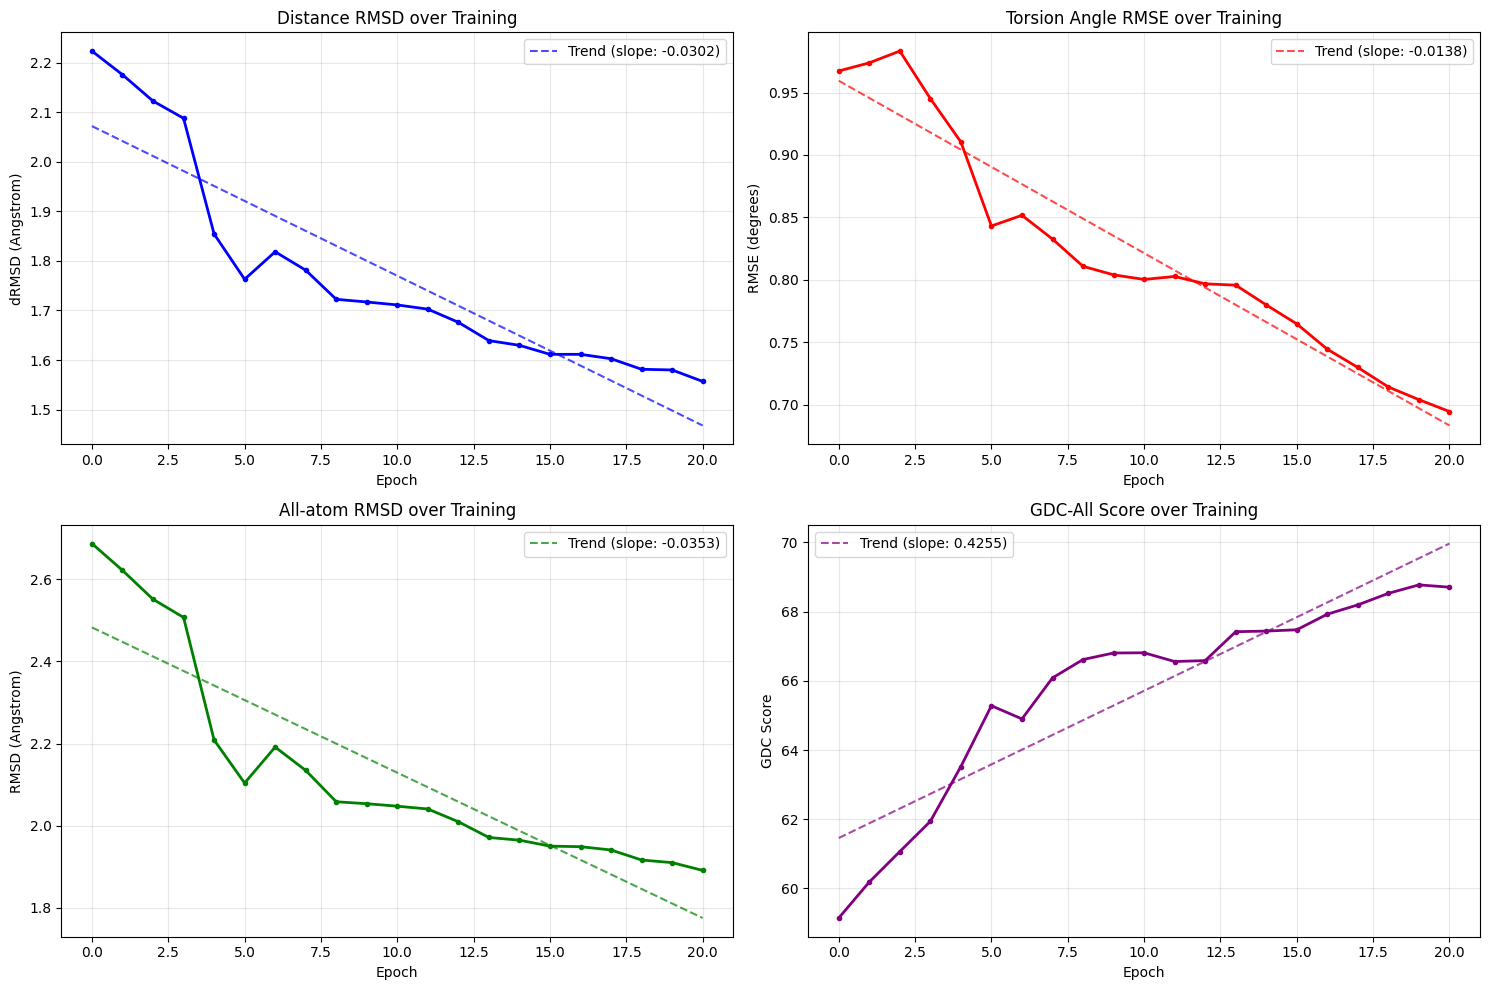

✓ Training metrics plot saved

         TEST SET EVALUATION

              COMPREHENSIVE TEST EVALUATION
Batch 1: dRMSD=1.406Å, Torsion RMSE=0.673°, RMSD=1.719Å, GDC=74.923
Batch 2: dRMSD=1.572Å, Torsion RMSE=0.675°, RMSD=1.888Å, GDC=72.333

         TEST SET SUMMARY
dRMSD: 1.489 ± 0.083 Å
Torsion RMSE: 0.674 ± 0.001°
All-atom RMSD: 1.803 ± 0.085 Å
GDC-All: 73.628 ± 1.295

                         RESULTS SUMMARY TABLE
                    (Following Paper Table Format)
Scenario             dRMSD (Å)    Torsion RMSE (°) All-atom RMSD (Å)  GDC-All   
--------------------------------------------------------------------------------
Current Model        1.557        0.695           1.891              68.707    
Test Set             1.489        0.674           1.803              73.628    

           DETAILED SINGLE PROTEIN ANALYSIS
Protein ID: TBM#T0865
Length: 62 residues
dRMSD (paper metric): 1.869 Å
All-atom RMSD: 1.811 Å
GDC-All: 66.667
Torsion RMSE (φ,ψ,ω): 0.000°

Analysis complete!

In [77]:
# Run comprehensive analysis
test_summary = analyze_results_like_paper(
    model, 
    test_loader=data['test'], 
    save_plots=True
)

# The function will automatically:
# 1. Create paper-style plots
# 2. Evaluate on test set  
# 3. Generate results table
# 4. Provide detailed protein analysis

In [37]:
import torch
import numpy as np
from sidechainnet.dataloaders.SCNProtein import SCNProtein
from sidechainnet.dataloaders.ProteinBatch import ProteinBatch

# Path to your local PDB file
pdb_file = "1AON.pdb"

# Create SCNProtein object from the PDB
protein = SCNProtein.from_pdb(
    filename=pdb_file,
    chid="A",       # Chain ID if you want a specific chain
    pdbid="1AON",   # Optional 4-letter PDB ID
    include_resolution=False,  # True if you want to query the PDB for resolution
    allow_nan=False,           # Whether to allow NaNs in structure
    suppress_warnings=False
)

true_protein = SCNProtein.from_pdb(
    filename=pdb_file,
    chid="A",       # Chain ID if you want a specific chain
    pdbid="1AON",   # Optional 4-letter PDB ID
    include_resolution=False,  # True if you want to query the PDB for resolution
    allow_nan=False,           # Whether to allow NaNs in structure
    suppress_warnings=False
)

print(f"Sequence: {protein.seq}")
print(f"Coordinates shape: {protein.coords.shape}")
print(f"Angles shape: {protein.angles.shape}")

model_args = {
    # Model architecture
    "sequence_only": True,
    "d_seq_embedding": 128,
    "d_in": 192,
    "d_feedforward": 384,
    "n_heads": 4,
    "n_layers": 6,
    "transformer_activation": 'gelu',

    # Model Training - CHANGE THIS:
    "batch_size": 32,
    "opt_n_warmup_steps": 2000,
    "opt_lr": 5e-5,
    "opt_lr_scheduling": 'plateau',  # CHANGED FROM 'cosine' TO 'plateau'
    "opt_patience": 10,             # UPDATED TO MATCH SCHEDULER
    "opt_weight_decay": 5e-3,
    "dropout": 0.25,
    "log_structures": False
}

# 1. Load your trained model
model = EnhancedLitSidechainTransformerDemo(**model_args)
# model.load_state_dict(torch.load("09oct_true_improved.ckpt"))
model = EnhancedLitSidechainTransformerDemo.load_from_checkpoint("oct09_base_true.ckpt")
model.eval()
print("✅ Model loaded successfully!")

# 2. Input sequence
sequence = protein.seq
print(f"Length: {len(sequence)} residues")

# 3. Convert sequence to encoded integers
encoded = VOCAB.str2ints(sequence)
seq_tensor = torch.tensor(encoded[1:-1]).unsqueeze(0)  # Add batch dimension
print(f"Encoded sequence: {encoded}")


# x_dummy = torch.zeros((1, len(encoded[1:-1]), model_args["d_in"]))
# x_input = torch.randn((1, len(encoded[1:-1]), model_args["d_in"]))
x_input = torch.zeros(1, 1, 0)

with torch.no_grad():
    sc_angs_pred = model(x_input, seq_tensor)

sc_angs_pred_rad = inverse_trig_transform(sc_angs_pred, n_angles=6)    
    
length = len(protein)
protein.angles[:length, 6:] = sc_angs_pred_rad[:length]  # np.ndarray with shape (L, 14)
protein.fastbuild(inplace=True)

protein.to_pdb("1AON_predicted_protein.pdb")
true_protein.to_pdb("1AON_true_protein.pdb")

Sequence: AAKDVKFGNDARVKMLRGVNVLADAVKVTLGPKGRNVVLDKSFGAPTITKDGVSVAREIELEDKFENMGAQMVKEVASKANDAAGDGTTTATVLAQAIITEGLKAVAAGMNPMDLKRGIDKAVTAAVEELKALSVPCSDSKAIAQVGTISANSDETVGKLIAEAMDKVGKEGVITVEDGTGLQDELDVVEGMQFDRGYLSPYFINKPETGAVELESPFILLADKKISNIREMLPVLEAVAKAGKPLLIIAEDVEGEALATLVVNTMRGIVKVAAVKAPGFGDRRKAMLQDIATLTGGTVISEEIGMELEKATLEDLGQAKRVVINKDTTTIIDGVGEEAAIQGRVAQIRQQIEEATSDYDREKLQERVAKLAGGVAVIKVGAATEVEMKEKKARVEDALHATRAAVEEGVVAGGGVALIRVASKLADLRGQNEDQNVGIKVALRAMEAPLRQIVLNCGEEPSVVANTVKGGDGNYGYNAATEEYGNMIDMGILDPTKVTRSALQYAASVAGLMITTECMVTDLP
Coordinates shape: (524, 15, 3)
Angles shape: (524, 12)
✅ Model loaded successfully!
Length: 524 residues
Encoded sequence: [20, 0, 0, 8, 2, 17, 8, 4, 5, 11, 2, 0, 14, 17, 8, 10, 9, 14, 5, 17, 11, 17, 9, 0, 2, 0, 17, 8, 17, 16, 9, 5, 12, 8, 5, 14, 11, 17, 17, 9, 2, 8, 15, 4, 5, 0, 12, 16, 7, 16, 8, 2, 5, 17, 15, 17, 0, 14, 3, 7, 3, 9, 3, 2, 8, 4, 3, 11, 10, 5, 0, 13, 10, 17, 8, 3, 17, 0, 15, 8, 0, 11, 2, 0, 0, 5, 2, 5, 16, 16, 16, 0, 16, 17, 9, 0, 13, 0, 7, 7, 

In [38]:
protein.to_3Dmol()
# true_protein.to_3Dmol()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [34]:
true_protein.to_3Dmol()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.